In [1]:
from formulae.terms.call_resolver import get_function_from_module
from formulae import design_matrices

import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
from bambi.backend.utils import get_distribution

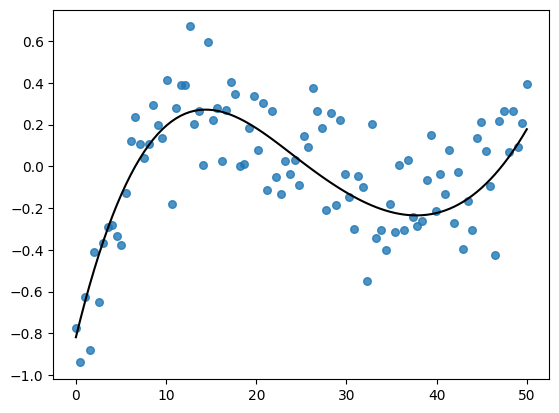

In [3]:
rng = np.random.default_rng(seed=121195)

N = 100
x = np.linspace(0, 50, N)
b = 0.1 * rng.normal(size=5)
sigma_t = 0.2

dm = design_matrices("0 + bs(x, df=5, intercept=True)", pd.DataFrame({"x": x}))
X = np.array(dm.common)
f = 10 * X @ b
y = f + sigma_t * rng.normal(size=N)

fig, ax = plt.subplots()
ax.scatter(x, y, s=30, alpha=0.8);
ax.plot(x, f, color="black");

In [18]:
class HSGP:
    def __call__(self, *x, m, L=None, c=None, by=None, cov="ExpQuad", drop_first=False, centered=False):
        self.by = by
        self.m = m
        self.L = L
        self.c = c
        self.by = by
        self.cov = cov
        self.drop_first = drop_first
        self.centered = centered
        return np.column_stack(x)

hsgp = HSGP()

In [19]:
m = [10]
df = pd.DataFrame({"x": x, "y": y})
dm = design_matrices("y ~ 1 + hsgp(x, m=m, c=2)", df)

In [20]:
dm

DesignMatrices

                  (rows, cols)
Response:               (100,)
Common:               (100, 2)

Use .reponse, .common, or .group to access the different members.

In [21]:
from formulae.terms.call import Call
from formulae.terms.call_resolver import get_function_from_module


def is_single_component(term):
    return hasattr(term, "components") and len(term.components) == 1


def extract_first_component(term):
    return term.components[0]


def is_call_component(component):
    return isinstance(component, Call)


def is_caller_of_instance(caller, kind):
    function = get_function_from_module(caller.call.callee, caller.env)
    return isinstance(function, kind)


def is_hsgp_term(term):
    if not is_single_component(term):
        return False
    component = extract_first_component(term)
    if not is_call_component(component):
        return False
    return is_caller_of_instance(component, HSGP)


def extract_hsgp_kwargs(term):
    component = extract_first_component(term)
    caller = get_function_from_module(component.call.callee, component.env)
    return caller.__dict__

In [22]:
for name, term in dm.common.terms.items():
    if is_hsgp_term(term):
        print(name)
        print(extract_hsgp_kwargs(term))

hsgp(x, m = m, c = 2)
{'by': None, 'm': [10], 'L': None, 'c': 2, 'cov': 'ExpQuad', 'drop_first': False, 'centered': False}


In [23]:
class HSGPTerm:
    def __init__(self, term, prior, prefix=None):
        self.term = term
        self.prior = prior # I think this may need to be dictionary
        self.data = np.squeeze(term.data)
        self.prefix = prefix
        self.hsgp_attrs = extract_hsgp_kwargs(term)

    @property
    def term(self):
        return self._term

    @term.setter
    def term(self, value):
        #assert isinstance(value, formulae.terms.terms.Term)
        self._term = value

    @property
    def m(self):
        return self.hsgp_attrs["m"]

    @property
    def L(self):
        return self.hsgp_attrs["L"]

    @property
    def c(self):
        return self.hsgp_attrs["c"]

    @property
    def cov(self):
        return self.hsgp_attrs["cov"]

    @property
    def centered(self):
        return self.hsgp_attrs["centered"]

    @property
    def drop_first(self):
        return self.hsgp_attrs["drop_first"]

    @property
    def prior(self):
        return self._prior

    @prior.setter
    def prior(self, value):
        # assert isinstance(value, VALID_PRIORS), f"Prior must be one of {VALID_PRIORS}"
        self._prior = value

    @property
    def coords(self):
        # TODO?
        return {}

    @property
    def name(self):
        # TODO
        return "HSGPTerm"

In [24]:
# In Bambi we don't work with PyMC distributions directly. These are resolved under the hood.
prior = {
    "sigma": bmb.Prior("Exponential", lam=2),
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1)
}

In [25]:
def bmb_exp_quad(sigma, ell):
    return sigma ** 2 * pm.gp.cov.ExpQuad(1, ls=ell)

GP_KERNELS = {            
    "ExpQuad": {
        "fn": bmb_exp_quad,
        "params": ("sigma", "ell")
    },
}

In [26]:
class BackendHSGPTerm:
    def __init__(self, term):
        self.term = term
        self.coords = self.term.coords.copy()
        if self.coords and self.term.alias:
            self.coords[self.term.alias + "_dim"] = self.coords.pop(self.term.name + "_dim")

    def build(self, spec):
        label = self.term.name
        # Build priors
        cov_params_priors = self.get_cov_func_priors(self.term)

        # Build covariance function
        cov_func = self.get_cov_func()

        # Build covariate function
        cov = cov_func(**cov_params_priors)

        # Build GP
        gp = pm.gp.HSGP(
            m=self.term.m, c=self.term.c, L=self.term.L, drop_first=self.term.drop_first, 
            cov_func=cov
        )

        # Get prior components
        # NOTE: See one dimension is added
        phi, sqrt_psd = gp.prior_components(X=self.term.data[:, None])

        # Build deterministic
        # TODO: Add more appropriate names to parameters
        if self.term.centered:
            coeffs = pm.Normal(f"{label}_coeffs", sigma=sqrt_psd)
            output = pm.Deterministic(label, phi @ coeffs)
        else:
            coeffs = pm.Normal(f"{label}_coeffs", size=sqrt_psd.size)
            output = pm.Deterministic(label, phi @ (coeffs * sqrt_psd))
        return output

    def get_cov_func(self):
        return GP_KERNELS[self.term.cov]["fn"]

    def get_cov_func_priors(self, priors):
        names = GP_KERNELS[self.term.cov]["params"]
        priors = {}
        for name in names:
            prior = self.term.prior[name]
            distribution = get_distribution(prior.name)
            coef = distribution(f"{self.term.name}_{name}", **prior.args)
            priors[name] = coef
        return priors

In [27]:
fm_term = dm.common.terms["hsgp(x, m = m, c = 2)"]
bmb_term = HSGPTerm(fm_term, prior=prior)
pymc_term = BackendHSGPTerm(bmb_term)

* $\phi$ is of shape $(n, m)$
* $\text{psd}$ is of shape $(m, )$
* $\beta$ is of shape $(m, )$
* $f$ is of shape $(n, )$

In [28]:
with pm.Model() as model:    
    f = pymc_term.build(None)
    sigma = pm.HalfNormal("sigma", sigma=10)
    pm.Normal("lik", mu=f, sigma=sigma, observed=df["y"])

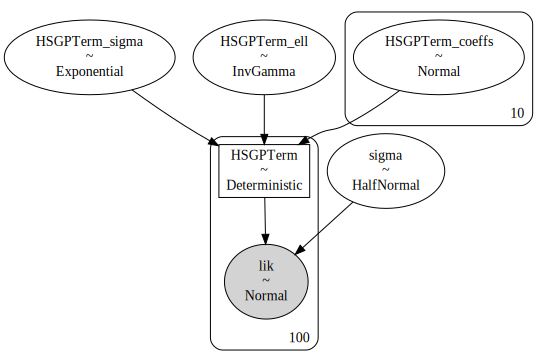

In [29]:
pm.model_to_graphviz(model)

In [30]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [HSGPTerm_sigma, HSGPTerm_ell, HSGPTerm_coeffs, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31 seconds.


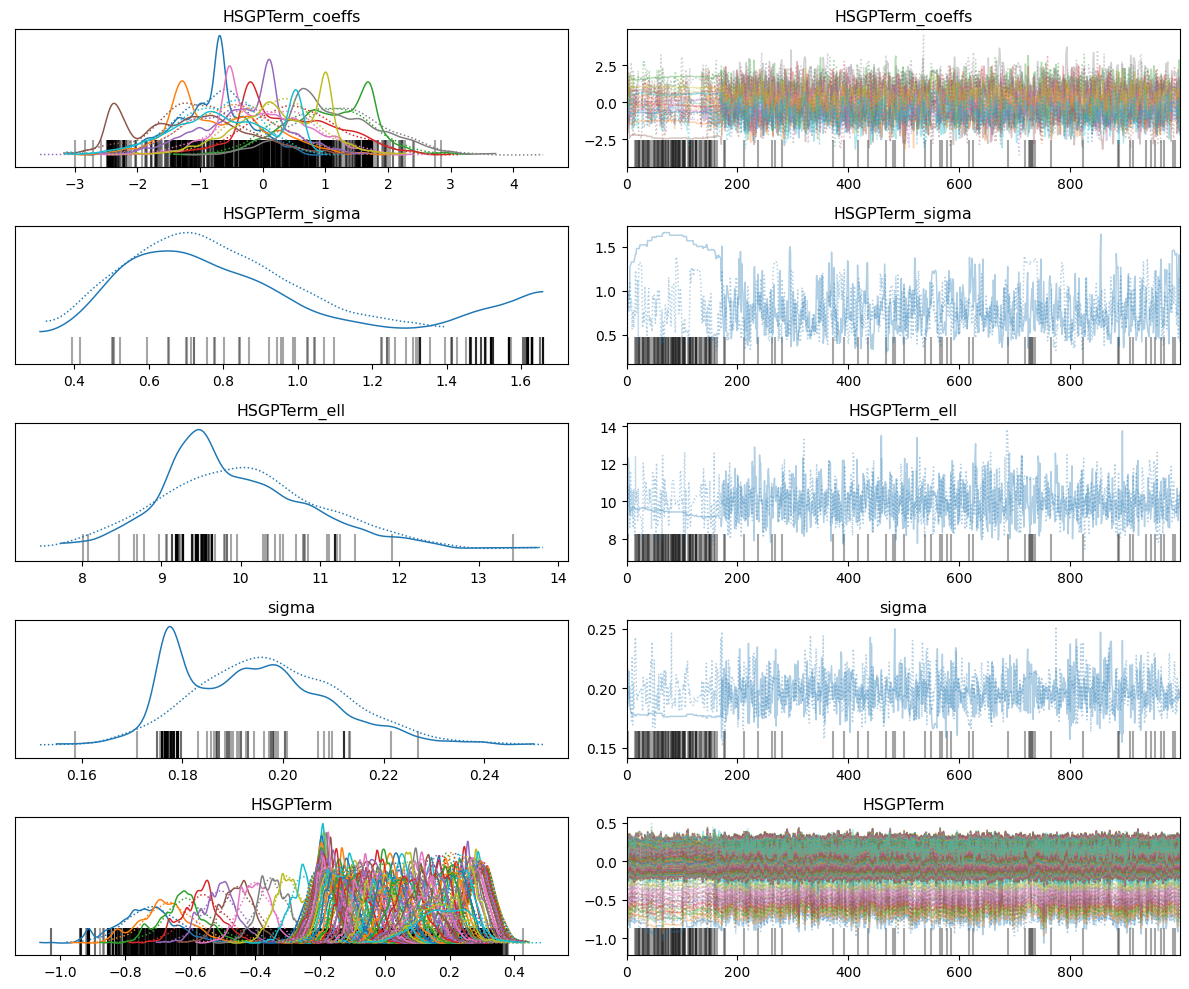

In [31]:
import arviz as az

az.plot_trace(idata, backend_kwargs={"layout": "tight"});